In [1]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg


# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)

                           
# # scale the source
linalg.scale('wstar.su',1000)

# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 8
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# linalg.simplot(dstar.data, addcb=True, minval=2.5, maxval=4.5)  


# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')
# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')


# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)


# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001 
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution 
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)



 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 0.093455
k = 1 alpha = 1.0 f = 0.0934275 ||df|| = 0.0052678173848378605
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
s^Ty = 2.39864e-08
 
eps*s^Ty = 2.6433175821304564e-22
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 0.0934275
k = 2 alpha = 1.0 f = 0.07571 ||df|| = 0.0025415959553005273
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
s^Ty = 0.0155907
 
eps*s^Ty = 1.696130011821028e-16
 
Iteration 3 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 0.07571
k = 3 alpha = 1.0 f = 0.0678345 ||df|| = 0.0021099644546769027
-----------------------------------------------------------------------------
---

 
s^Ty = 3.98972e-06
 
eps*s^Ty = 7.355021193987139e-20
 
Iteration 22 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 7.6188e-05
k = 22 alpha = 1.0 f = 6.54865e-05 ||df|| = 2.3427291776899863e-05
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
s^Ty = 6.59712e-06
 
eps*s^Ty = 1.4662169589116067e-19
 
Iteration 23 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 6.54865e-05
k = 23 alpha = 1.0 f = 5.05015e-05 ||df|| = 1.9700913684395454e-05
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
s^Ty = 1.38307e-05
 
eps*s^Ty = 2.9440178013728107e-19
 
Iteration 24 of LBFGS:
i is the iteration counter for line search.
i = 0 alpha = 0 f(x) =  + 5.05015e-05
k = 24 alpha = 1.0 f = 4.719875e-05 ||df|| = 4.538479921735911e-

 
 The initial slowness:
 
colmax=4.5 colmin=2.5


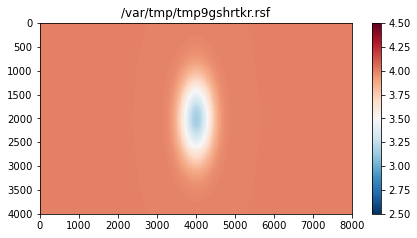

simplot: data min = 3.1607e+00, data max = 4.0000e+00


In [2]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The resulted slowness from LBFGS:
 
colmax=4.5 colmin=2.5


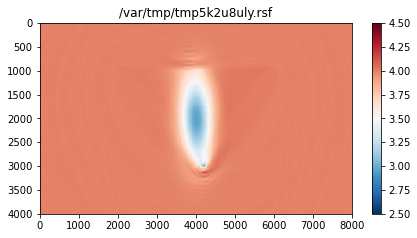

simplot: data min = 2.9553e+00, data max = 4.1321e+00


In [3]:
# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The resulted slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The target slowness:
 
colmax=4.5 colmin=2.5


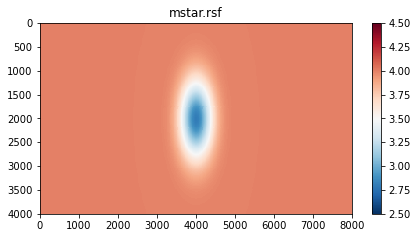

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [4]:
print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

 
 The initial data:
 
colmax=0.004 colmin=-0.004


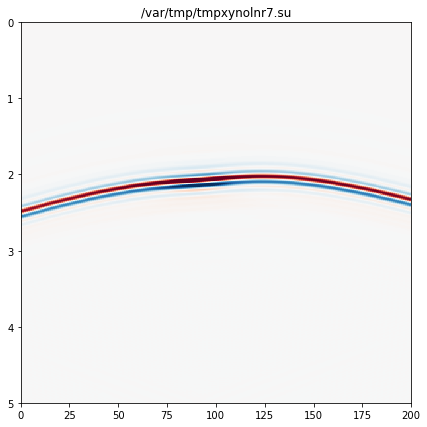

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


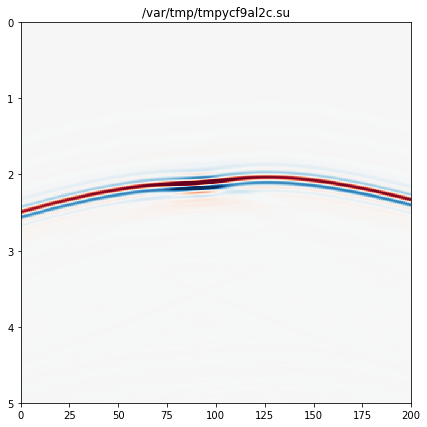

simplot: data min = -7.3809e-03, data max = 8.5818e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


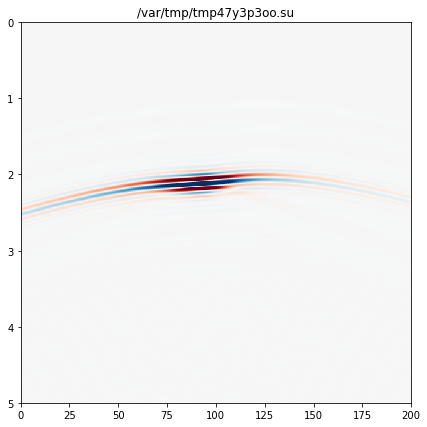

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


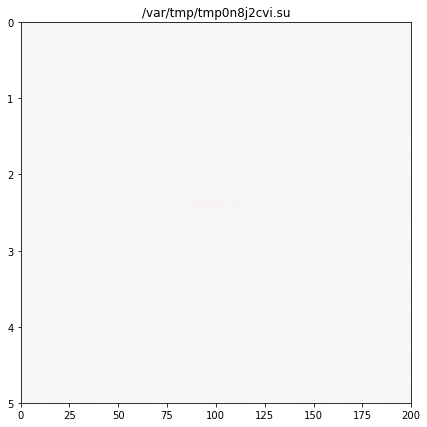

simplot: data min = -6.3163e-05, data max = 1.2189e-04
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 3.4513e-07


In [5]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))